In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import argparse
import collections
import datetime
import gc
import glob
import logging
import math
import operator
import os
import pickle
import pkg_resources
import random
import re
import scipy.stats as stats
import seaborn as sns
import shutil
import sys
import time
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from contextlib import contextmanager
from collections import OrderedDict
# from nltk.stem import PorterStemmer

import scipy as sp
from sklearn import metrics
from sklearn import model_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.feature_extraction.text import _document_frequency
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from torch.nn import CrossEntropyLoss, MSELoss
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import (Dataset,DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
%load_ext autoreload
%autoreload 2
%matplotlib inline
# from tqdm import tqdm, tqdm_notebook, trange
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
tqdm.pandas()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
# from apex import amp

<ipython-input-1-6cabf720ad48>:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [ ]:
data = [(1, 5), (2, 2), (3, 9), (4, 1)]
key = lambda x: -x[1]  # 这是一个lambda函数，不是函数调用
data.sort(key=key)     # 直接将lambda函数作为key参数的值传递给sort方法
print(data)            # 打印排序后的列表

[(3, 9), (1, 5), (2, 2), (4, 1)]


In [ ]:
!apt install curl mecab libmecab-dev mecab-ipadic-utf8 file -y
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
%cd mecab-ipadic-neologd
!bin/install-mecab-ipadic-neologd -n -a -y --prefix /var/lib/mecab/dic/mecab-ipadic-neologd
!sed -i -e 's@^dicdir.*$@dicdir = /var/lib/mecab/dic/mecab-ipadic-neologd@' /etc/mecabrc
!pip install mecab-python3
%cd ../../input/
!ls

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
curl is already the newest version (7.81.0-1ubuntu1.16).
file is already the newest version (1:5.41-3ubuntu0.1).
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,367 kB of archives.
After this operation, 59.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab2 amd64 0.996-14build9 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab-dev amd64 0.996-14build9 [306 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-utils amd64 0.996-14build9 [4,850 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-ipadic all 2.7.0-20070801+main-3 [6,718 kB]
Get:5 http://

In [ ]:
pip install mecab-python3

In [ ]:
pip install unidic-lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=f2ea2e67147320914a6aef590ae2a47e6728af2b843f1d7f4686bd6e4ee7b45e
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite


In [ ]:
import MeCab

class MecabTokenizer:
    def __init__(self):
        self.wakati = MeCab.Tagger('-Owakati')
        self.wakati.parse('')

    def tokenize(self, line):
        txt = self.wakati.parse(line)
        txt = txt.split()
        return txt

    def mecab_tokenizer(self, line):
        node = self.wakati.parseToNode(line)
        keywords = []
        while node:
            if node.feature.split(",")[0] == "名詞":
                keywords.append(node.surface)
            node = node.next
        return keywords

In [ ]:
tagger = MeCab.Tagger('-r/dev/null -d/home/hoge/mydic')

RuntimeError: 
----------------------------------------------------------

Failed initializing MeCab. Please see the README for possible solutions:

    https://github.com/SamuraiT/mecab-python3#common-issues

If you are still having trouble, please file an issue here, and include the
ERROR DETAILS below:

    https://github.com/SamuraiT/mecab-python3/issues

issueを英語で書く必要はありません。

------------------- ERROR DETAILS ------------------------
arguments: -r/dev/null -d/home/hoge/mydic
default dictionary path: /usr/local/lib/python3.10/dist-packages/unidic_lite/dicdir
[ifs] no such file or directory: /home/hoge/mydic/dicrc
----------------------------------------------------------


In [ ]:
import MeCab
wakati = MeCab.Tagger("-Owakati")
wakati.parse("pythonが大好きです").split()


tagger = MeCab.Tagger()
print(tagger.parse("pythonが大好きです"))

['python', 'が', '大好き', 'です']

python	python	python	python	名詞-普通名詞-一般			0
が	ガ	ガ	が	助詞-格助詞			
大好き	ダイスキ	ダイスキ	大好き	形状詞-一般			1
です	デス	デス	です	助動詞	助動詞-デス	終止形-一般	
EOS



In [ ]:
tok = MecabTokenizer()
tok.mecab_tokenizer("kaggle days 楽しいイベントでしたね。")

['kaggle', 'days', 'イベント']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# read txt files

In [ ]:
content_set = []
num = 0

In [ ]:
folder_path_1 = '/content/drive/MyDrive/txt data final'
folder_path_2 = '/content/drive/MyDrive/txt data final/inserted label'
folder_path_3 = '/content/drive/MyDrive/txt data final/without inserted label'

current_path = folder_path_1

for filename in os.listdir(current_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(current_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            content_set.append(content)
            num += 1

#print(content_set)
print(num)

36


In [ ]:
folder_path_1 = '/content/drive/MyDrive/txt data final'
folder_path_2 = '/content/drive/MyDrive/txt data final/inserted label'
folder_path_3 = '/content/drive/MyDrive/txt data final/without inserted label'

current_path = folder_path_2

for filename in os.listdir(current_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(current_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            content_set.append(content)
            num += 1

#print(content_set)
print(num)

62


In [ ]:
folder_path_1 = '/content/drive/MyDrive/txt data final'
folder_path_2 = '/content/drive/MyDrive/txt data final/inserted label'
folder_path_3 = '/content/drive/MyDrive/txt data final/without inserted label'

current_path = folder_path_3

for filename in os.listdir(current_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(current_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            content_set.append(content)
            num += 1

#print(content_set)
print(num)

79


In [ ]:
df = pd.DataFrame(columns=['text'])
# 加上一列 文章id
df.text = pd.DataFrame(content_set)
print(df.shape)
df.head()

(79, 1)


,text
0,https://machicon.jp/koigaku/column/385995/\n\n...
1,https://woman.excite.co.jp/article/love/rid_Ai...
2,https://goukaku-suppli.com/archives/56287#goog...
3,https://www.uchina-web.co.jp/fortune/whiteday-...
4,https://mrs.living.jp/k_life/article/2266657#g...


# Preprocessing

In [ ]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\n', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]


html_tags = ['<p>', '</p>', '<table>', '</table>', '<tr>', '</tr>', '<ul>', '<ol>', '<dl>', '</ul>', '</ol>',
             '</dl>', '<li>', '<dd>', '<dt>', '</li>', '</dd>', '</dt>', '<h1>', '</h1>',
             '<br>', '<br/>', '<strong>', '</strong>', '<span>', '</span>', '<blockquote>', '</blockquote>',
             '<pre>', '</pre>', '<div>', '</div>', '<h2>', '</h2>', '<h3>', '</h3>', '<h4>', '</h4>', '<h5>', '</h5>',
             '<h6>', '</h6>', '<blck>', '<pr>', '<code>', '<th>', '</th>', '<td>', '</td>', '<em>', '</em>']

empty_expressions = ['&lt;', '&gt;', '&amp;', '&nbsp;',
                     '&emsp;', '&ndash;', '&mdash;', '&ensp;'
                     '&quot;', '&#39;']

other = ['span', 'style', 'href', 'input']


def pre_preprocess(x):
    return str(x).lower()

def rm_spaces(text):
    spaces = ['\u200b', '\u200e', '\u202a', '\u2009', '\u2028', '\u202c', '\ufeff', '\uf0d8', '\u2061', '\u3000', '\x10', '\x7f', '\x9d', '\xad',
              '\x97', '\x9c', '\x8b', '\x81', '\x80', '\x8c', '\x85', '\x92', '\x88', '\x8d', '\x80', '\x8e', '\x9a', '\x94', '\xa0',
              '\x8f', '\x82', '\x8a', '\x93', '\x90', '\x83', '\x96', '\x9b', '\x9e', '\x99', '\x87', '\x84', '\x9f',
             ]
    for space in spaces:
            text = text.replace(space, ' ')
    return text

def remove_urls(x):
    x = re.sub(r'(https?://[a-zA-Z0-9.-]*)', r'', x)

    # original
    x = re.sub(r'(quote=\w+\s?\w+;?\w+)', r'', x)
    return x

def clean_html_tags(x, stop_words=[]):
    for r in html_tags:
        x = x.replace(r, '')
    for r in empty_expressions:
        x = x.replace(r, ' ')
    for r in stop_words:
        x = x.replace(r, '')
    return x

def replace_num(text):
    text = re.sub('[0-9]{5,}', '', text)
    text = re.sub('[0-9]{4}', '', text)
    text = re.sub('[0-9]{3}', '', text)
    text = re.sub('[0-9]{2}', '', text)
    return text

def get_url_num(x):
    pattern = "https?://[\w/:%#\$&\?\(\)~\.=\+\-]+"
    urls = re.findall(pattern, x)
    return len(urls)


def clean_puncts(x):
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

#zenkaku = '０,１,２,３,４,５,６,７,８,９,（,）,＊,「,」,［,］,【,】,＜,＞,？,・,＃,＠,＄,％,＝'.split(',')
#hankaku = '0,1,2,3,4,5,6,7,8,9,q,a,z,w,s,x,c,d,e,r,f,v,b,g,t,y,h,n,m,j,u,i,k,l,o,p'.split(',')

def clean_text_jp(x):
    x = x.replace('。', '')
    x = x.replace('、', '')
    x = x.replace('\n', '') # 改行削除
    x = x.replace('\t', '') # タブ削除
    x = x.replace('\r', '')
    x = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', x)
    x = re.sub(r'\[math\]', ' LaTex math ', x) # LaTex削除
    x = re.sub(r'\[\/math\]', ' LaTex math ', x) # LaTex削除
    x = re.sub(r'\\', ' LaTex ', x) # LaTex削除
    #for r in zenkaku+hankaku:
    #    x = x.replace(str(r), '')
    x = re.sub(' +', ' ', x)
    return x


def preprocess(data):
    data = pre_preprocess(data)
    data = rm_spaces(data)
    data = remove_urls(data)
    data = clean_puncts(data)
    data = replace_num(data)
    data = clean_html_tags(data, stop_words=other)
    data = clean_text_jp(data)
    return data

In [ ]:
for i in range((df['text'].shape)[0]):
  df['text'].iloc[i] = preprocess(df['text'].iloc[i])
print(df.shape)
df.head()

(79, 1)


,text
0,koigaku column ・ 「学生の頃チョコレートを手作りしようとしていたら 湯煎す...
1,article love rid aikatu 「好きだった彼が『守ってあげたくなるような...
2,archives google vignette ①大学受験の結果を自慢気に話してしまった...
3,fortune whiteday sippai ・ 義理のお返しで女性が好きそうな果物を使...
4,k life article google vignette ・ お酒を飲み過ぎで ポスト...


# TF-IDF

In [ ]:
df['wakati_text'] = df['text'].progress_apply(lambda x: ' '.join(tok.mecab_tokenizer(x)))
df.head()

  0%|          | 0/79 [00:00<?, ?it/s]

,text,wakati_text
0,koigaku column ・ 「学生の頃チョコレートを手作りしようとしていたら 湯煎す...,koigaku column 学生 頃 チョコレート 手作り 湯煎 ため 湯 手 火傷 バレ...
1,article love rid aikatu 「好きだった彼が『守ってあげたくなるような...,article love rid aikatu 女の子 小耳 女性 前 体調 こと アピール...
2,archives google vignette ①大学受験の結果を自慢気に話してしまった...,archives google vignette ① 大学 受験 結果 自慢 気 共通 テス...
3,fortune whiteday sippai ・ 義理のお返しで女性が好きそうな果物を使...,fortune whiteday sippai 義理 返し 女性 果物 菓子 果物 苦手 家...
4,k life article google vignette ・ お酒を飲み過ぎで ポスト...,k life article google vignette 酒 ポスト 一生 笑 まる 歳...


In [ ]:
def get_sentence_features(train, col):
    train[col + '_num_chars'] = train[col].apply(len)
    train[col + '_num_words'] = train[col].apply(lambda x: len(x.split()))
    train[col + '_num_unique_words'] = train[col].apply(lambda comment: len(set(w for w in comment.split())))
    return train

df = get_sentence_features(df, 'wakati_text')
df.head()

,text,wakati_text,wakati_text_num_chars,wakati_text_num_words,wakati_text_num_unique_words
0,koigaku column ・ 「学生の頃チョコレートを手作りしようとしていたら 湯煎す...,koigaku column 学生 頃 チョコレート 手作り 湯煎 ため 湯 手 火傷 バレ...,446,140,88
1,article love rid aikatu 「好きだった彼が『守ってあげたくなるような...,article love rid aikatu 女の子 小耳 女性 前 体調 こと アピール...,267,83,63
2,archives google vignette ①大学受験の結果を自慢気に話してしまった...,archives google vignette ① 大学 受験 結果 自慢 気 共通 テス...,502,168,114
3,fortune whiteday sippai ・ 義理のお返しで女性が好きそうな果物を使...,fortune whiteday sippai 義理 返し 女性 果物 菓子 果物 苦手 家...,1082,334,170
4,k life article google vignette ・ お酒を飲み過ぎで ポスト...,k life article google vignette 酒 ポスト 一生 笑 まる 歳...,768,249,172


In [ ]:
n_components = 10
col_num = n_components * 2

SEED = 1129

word_vectorizer = make_pipeline(
                TfidfVectorizer(sublinear_tf=True,
                                strip_accents='unicode',
                                analyzer='word',
                                token_pattern=r'\w{1,}',
                                stop_words='english',
                                ngram_range=(1, 2),
                                max_features=20000),
                TruncatedSVD(n_components=n_components, random_state=SEED)
             )

char_vectorizer = make_pipeline(
                TfidfVectorizer(sublinear_tf=True,
                                strip_accents='unicode',
                                analyzer='char',
                                stop_words='english',
                                ngram_range=(1, 4),
                                max_features=50000),
                TruncatedSVD(n_components=n_components, random_state=SEED)
             )

wakati_text_wd = word_vectorizer.fit_transform(df['wakati_text']).astype(np.float32)
wakati_text_ch = char_vectorizer.fit_transform(df['wakati_text']).astype(np.float32)

X = np.concatenate([wakati_text_wd, wakati_text_ch], axis=1)
X = pd.DataFrame(X, columns=['text_wd_tfidf_svd_{}'.format(i) for i in range(col_num)])
#X = pd.DataFrame(X)
X.head()
print(X.shape)

,text_wd_tfidf_svd_0,text_wd_tfidf_svd_1,text_wd_tfidf_svd_2,text_wd_tfidf_svd_3,text_wd_tfidf_svd_4,text_wd_tfidf_svd_5,text_wd_tfidf_svd_6,text_wd_tfidf_svd_7,text_wd_tfidf_svd_8,text_wd_tfidf_svd_9,text_wd_tfidf_svd_10,text_wd_tfidf_svd_11,text_wd_tfidf_svd_12,text_wd_tfidf_svd_13,text_wd_tfidf_svd_14,text_wd_tfidf_svd_15,text_wd_tfidf_svd_16,text_wd_tfidf_svd_17,text_wd_tfidf_svd_18,text_wd_tfidf_svd_19
0,0.251597,0.098165,-0.072831,-0.229725,-0.102761,-0.114418,0.266132,-0.330454,-0.042390,0.047672,0.311721,0.099976,-0.019427,-0.177930,-0.041170,0.080938,-0.152941,0.396277,-0.153116,0.078609
1,0.152309,0.000948,0.002350,-0.160765,-0.146607,0.077942,-0.069734,-0.014131,-0.063454,-0.025161,0.228575,0.016931,0.020113,-0.222385,-0.086420,-0.018103,-0.109700,-0.053981,0.087886,-0.073591
2,0.172977,-0.051213,-0.072987,0.071352,0.026153,0.122651,0.021198,-0.049487,-0.064286,0.021553,0.281051,-0.046137,-0.125862,0.072935,-0.063931,-0.166216,-0.047434,-0.102550,-0.026992,0.158808
3,0.227100,0.096559,-0.111954,-0.141069,-0.092844,-0.073764,0.280702,-0.308711,-0.045087,0.116007,0.329879,0.077249,-0.078677,-0.159464,-0.073437,0.079349,-0.102818,0.373231,-0.204396,0.124506
4,0.188147,-0.013477,-0.095163,-0.066330,-0.199463,-0.058729,0.134149,0.084086,0.006634,0.014829,0.285119,0.023106,-0.106033,-0.162220,-0.110894,0.090587,0.165626,0.055780,-0.010103,0.045474


(79, 20)


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['text_wd_tfidf_svd_0'].plot(kind='hist', bins=20, title='text_wd_tfidf_svd_0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['text_wd_tfidf_svd_1'].plot(kind='hist', bins=20, title='text_wd_tfidf_svd_1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['text_wd_tfidf_svd_2'].plot(kind='hist', bins=20, title='text_wd_tfidf_svd_2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='text_wd_tfidf_svd_0', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='text_wd_tfidf_svd_0', y='text_wd_tfidf_svd_1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='text_wd_tfidf_svd_1', y='text_wd_tfidf_svd_2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='text_wd_tfidf_svd_2', y='text_wd_tfidf_svd_3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['text_wd_tfidf_svd_0']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('text_wd_tfidf_svd_0')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['text_wd_tfidf_svd_1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('text_wd_tfidf_svd_1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['text_wd_tfidf_svd_2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('text_wd_tfidf_svd_2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['text_wd_tfidf_svd_3']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('text_wd_tfidf_svd_3')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['text_wd_tfidf_svd_0'].plot(kind='line', figsize=(8, 4), title='text_wd_tfidf_svd_0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['text_wd_tfidf_svd_1'].plot(kind='line', figsize=(8, 4), title='text_wd_tfidf_svd_1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['text_wd_tfidf_svd_2'].plot(kind='line', figsize=(8, 4), title='text_wd_tfidf_svd_2')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import csv

# CSV文件路径
csv_file = '/content/drive/MyDrive/tf-idf data.csv'

df.to_csv(csv_file, index=False)

print(f"DataFrame saved to {csv_file}")

DataFrame saved to /content/drive/MyDrive/tf-idf data.csv


In [ ]:
df = pd.concat([df, X], axis=1)
print(df.shape)
df.head()

(79, 25)


,text,wakati_text,wakati_text_num_chars,wakati_text_num_words,wakati_text_num_unique_words,text_wd_tfidf_svd_0,text_wd_tfidf_svd_1,text_wd_tfidf_svd_2,text_wd_tfidf_svd_3,text_wd_tfidf_svd_4,...,text_wd_tfidf_svd_10,text_wd_tfidf_svd_11,text_wd_tfidf_svd_12,text_wd_tfidf_svd_13,text_wd_tfidf_svd_14,text_wd_tfidf_svd_15,text_wd_tfidf_svd_16,text_wd_tfidf_svd_17,text_wd_tfidf_svd_18,text_wd_tfidf_svd_19
0,koigaku column ・ 「学生の頃チョコレートを手作りしようとしていたら 湯煎す...,koigaku column 学生 頃 チョコレート 手作り 湯煎 ため 湯 手 火傷 バレ...,446,140,88,0.251597,0.098165,-0.072831,-0.229725,-0.102761,...,0.311721,0.099976,-0.019427,-0.177930,-0.041170,0.080938,-0.152941,0.396277,-0.153116,0.078609
1,article love rid aikatu 「好きだった彼が『守ってあげたくなるような...,article love rid aikatu 女の子 小耳 女性 前 体調 こと アピール...,267,83,63,0.152309,0.000948,0.002350,-0.160765,-0.146607,...,0.228575,0.016931,0.020113,-0.222385,-0.086420,-0.018103,-0.109700,-0.053981,0.087886,-0.073591
2,archives google vignette ①大学受験の結果を自慢気に話してしまった...,archives google vignette ① 大学 受験 結果 自慢 気 共通 テス...,502,168,114,0.172977,-0.051213,-0.072987,0.071352,0.026153,...,0.281051,-0.046137,-0.125862,0.072935,-0.063931,-0.166216,-0.047434,-0.102550,-0.026992,0.158808
3,fortune whiteday sippai ・ 義理のお返しで女性が好きそうな果物を使...,fortune whiteday sippai 義理 返し 女性 果物 菓子 果物 苦手 家...,1082,334,170,0.227100,0.096559,-0.111954,-0.141069,-0.092844,...,0.329879,0.077249,-0.078677,-0.159464,-0.073437,0.079349,-0.102818,0.373231,-0.204396,0.124506
4,k life article google vignette ・ お酒を飲み過ぎで ポスト...,k life article google vignette 酒 ポスト 一生 笑 まる 歳...,768,249,172,0.188147,-0.013477,-0.095163,-0.066330,-0.199463,...,0.285119,0.023106,-0.106033,-0.162220,-0.110894,0.090587,0.165626,0.055780,-0.010103,0.045474


In [ ]:
# fasttext

vocab = []

for text in tqdm(df['wakati_text']):
    for t in text.split():
        vocab.extend(tok.mecab_tokenizer(t))

vocab = list(set(vocab))
len(vocab)

  0%|          | 0/79 [00:00<?, ?it/s]

2887

In [ ]:
vocab

['自体',
 '米',
 'インテリア',
 '前半',
 '共通',
 '限り',
 'やる気',
 '変',
 '簡潔',
 'アーモンド',
 '誤字',
 '業者',
 '燃焼',
 '期限',
 '逆走',
 '委縮',
 '娘',
 '本気',
 '禁物',
 '手続き',
 '遭遇',
 'ジョン',
 '熟語',
 '水辺',
 '休憩',
 '個人',
 '害虫',
 '解決',
 'コロナ',
 '料理',
 '姉',
 'バランス',
 'ボディー',
 'ネイリスト',
 '妊娠',
 'デリック',
 'ポテンシャル',
 'わが家',
 '脇',
 '謝罪',
 'ヘア',
 'カヴァー',
 '予約',
 'シッター',
 'ボンネット',
 '周辺',
 'ルート',
 '女の子',
 '研修',
 '運',
 'テスラ',
 '絶対',
 '目撃',
 'プレッシャー',
 'bthmedg',
 '不文',
 '数字',
 '消去',
 '貧乏',
 '所有',
 '喧嘩',
 '明治',
 '法',
 '悩み',
 '掲示',
 'h',
 '大学',
 'トーン',
 '意義',
 'フリーズ',
 '寝付き',
 '開花',
 'バースデー',
 '調理',
 '動揺',
 '礼',
 '製品',
 '恰好',
 '存在',
 '興味',
 '杞憂',
 'ビックリ',
 '片隅',
 '必需',
 '施設',
 '間違い',
 '乗車',
 '基礎',
 '放浪',
 '指輪',
 '訳',
 '我が家',
 '運命',
 '先',
 '深夜',
 '空回り',
 '術',
 'wt',
 '返金',
 '友だち',
 '間',
 '彼氏',
 '数学',
 '裸',
 '占い',
 '従業',
 '仲',
 '疲れ',
 '共働き',
 '活動',
 'tree',
 '仕組み',
 'アクセサリー',
 '仕様',
 '食料',
 '逆なで',
 '折',
 '柚子',
 '特急',
 '中途',
 '四',
 '孤独',
 'シフト',
 '再会',
 'ほとんど',
 'やりとり',
 '調整',
 'ちそう',
 '鍵穴',
 '準備',
 '赤本',
 '学び',
 'まり',
 '摩訶',
 'ラーメン',

In [ ]:
path_w = '/content/drive/MyDrive/txt data final/content_vocab.txt'

with open(path_w, mode='w') as f:
    for l in tqdm(df['wakati_text'].values):
        f.write('\n')
        f.write(l)

  0%|          | 0/79 [00:00<?, ?it/s]

1

446

1

267

1

502

1

1082

1

768

1

514

1

389

1

178

1

734

1

1438

1

179

1

1694

1

385

1

418

1

416

1

691

1

2078

1

2459

1

343

1

249

1

2250

1

304

1

687

1

295

1

304

1

477

1

839

1

1448

1

1623

1

317

1

804

1

593

1

940

1

253

1

543

1

882

1

137

1

104

1

58

1

23

1

55

1

71

1

77

1

31

1

122

1

46

1

64

1

106

1

79

1

77

1

62

1

17

1

24

1

20

1

27

1

43

1

21

1

30

1

23

1

17

1

23

1

56

1

1295

1

772

1

443

1

94

1

115

1

97

1

99

1

179

1

123

1

734

1

1198

1

1338

1

396

1

234

1

36

1

475

1

103

In [ ]:
!cat /content/drive/MyDrive/txt data final/content_vocab.txt

cat: /content/drive/MyDrive/txt: No such file or directory
cat: data: No such file or directory
cat: final/content_vocab.txt: No such file or directory


# similarity


In [ ]:
# 假设你已经有了一个分词和TF-IDF计算的工具或库
from some_japanese_nlp_library import MeCabTokenizer, TfidfVectorizer

# 假设你有一个用户标记为“有用”的文章列表和对应的文本Id
labeled_articles = [
    {"label": "有用", "text": "文章1のid..."},
    {"label": "有用", "text": "文章2のid..."},
    # ...
]

# 分词并构建TF-IDF模型
tokenizer = MeCabTokenizer()
vectorizer = TfidfVectorizer()

# 对用户标记为“有用”的文章进行TF-IDF计算
#useful_articles_tfidf = []
#for article in labeled_articles:
#       tokens = tokenizer.tokenize(article["text"])
#        tfidf_vector = vectorizer.fit_transform([tokens])
#        useful_articles_tfidf.append(tfidf_vector.toarray()[0])

# 直接建立文章的TF-IDF向量的矩阵
# 直接按index提取
useful_articles_tfidf = []
for article in labeled_articles:


# 聚合用户偏好的TF-IDF向量（例如，取平均值）
user_preference_vector = np.mean(useful_articles_tfidf, axis=0)

# 假设你有一个待推荐的文章列表
articles_to_recommend = [
    {"text": "候補文章1の内容..."},
    {"text": "候補文章2の内容..."},
    # ...
]

# 对待推荐文章进行TF-IDF计算，并计算相似度
recommendations = []
for article in articles_to_recommend:
    tokens = tokenizer.tokenize(article["text"])
    tfidf_vector = vectorizer.transform([tokens])
    similarity = cosine_similarity(tfidf_vector.toarray(), [user_preference_vector])
    recommendations.append({"text": article["text"], "similarity": similarity[0][0]})

# 按照相似度排序并推荐
recommendations.sort(key=lambda x: x["similarity"], reverse=True)
for rec in recommendations[:N]:  # N是你想要推荐的文章数量
    print(f"推荐: {rec['text']}, 相似度: {rec['similarity']}")

# kmeans

In [ ]:
# 提取txt file_name
import os
import glob

num = 0
file_names = []

folder_path_1 = '/content/drive/MyDrive/txt data final'
folder_path_2 = '/content/drive/MyDrive/txt data final/inserted label'
folder_path_3 = '/content/drive/MyDrive/txt data final/without inserted label'

folder_path = folder_path_1

txt_files = glob.glob(os.path.join(folder_path, '*.txt'))

for file_name in txt_files:
  print(os.path.basename(file_name))
  file_names.append(os.path.basename(file_name))
  num += 1

print(num)

血だらけでチョコ配達⁉ バレンタインデーの失敗談6つ.txt
今なら笑える！片思い中の失敗エピソード.txt
【新大学生必見】これだけはやるな！入学直後の失敗談とそこから学ぶ教訓6選.txt
ホワイトデーで失敗…。良くないプレゼントや忘れていた悲しいエピソード.txt
やってしまった～！ お花見での失敗エピソード.txt
新入社員にアドバイス！ 働く女性100人がこっそり明かす “今だから言える“新人時代のやらかし話＆失敗のリカバリー法.txt
破局のきっかけになった！彼氏とのデートの失敗談5つ.txt
結納・顔合わせ食事会「こんなはずでは！」衝撃失敗談５.txt
大学生活の印象的な失敗談.txt
【新人は失敗だらけ？】入社一年目の失敗を出版社の先輩たちに聞いてみたら.txt
ＳＮＳへの投稿で「失敗した…」ことってある？.txt
定期テストでのハプニング・失敗談【中学生保護者の声】.txt
やってみたかった仕事に就いたのに……。こんなはずじゃなかった.txt
なんとなく転職したけど、私のやりたいことって本当にこれだっけ.txt
こんな大学の決め方は絶対NG！先輩が語る、進路選択の後悔体験談.txt
就活の面接時によくある失敗例｜学生による体験談や人事担当者の経験を紹介.txt
先輩のありがち失敗談に学ぶ！「新居選び＆引っ越し」成功術.txt
大学受験に失敗したら？進路の選択肢7つと落ちたらするべき3つのこと.txt
入社後に発覚　求人票や面接で聞いた労働条件が違う.txt
ワンマン社長がいた　振り回される毎日を送る羽目に.txt
入試当日の失敗談・エピソード…今春卒業生の声を集めました.txt
日本一時帰国の時にやらかしまくってる.txt
不登校から進学して、大学生活で大失敗した話.txt
大学3年生大きな声では言えない失敗談6選.txt
思っていたより残業が多い、会議が長い……。早く帰れない.txt
確認しておこう　ふるさと納税よくある間違いとは.txt
留学失敗　ある留学失敗体験記.txt
他人事じゃない！みんなに聞いた結婚式に出席した時の失敗談.txt
共働き家庭の子育ての失敗談。対処法や仕事と家庭の両立のために利用したサービス.txt
ミスマッチ　希望を胸に転

In [ ]:
folder_path = folder_path_2

txt_files = glob.glob(os.path.join(folder_path, '*.txt'))

for file_name in txt_files:
  print(os.path.basename(file_name))
  file_names.append(os.path.basename(file_name))
  num += 1

print(num)

「やっちまった…」男性10人の初デート失敗談2.txt
「やっちまった…」男性10人の初デート失敗談1.txt
「やっちまった…」男性10人の初デート失敗談3.txt
「やっちまった…」男性10人の初デート失敗談4.txt
「やっちまった…」男性10人の初デート失敗談5.txt
「やっちまった…」男性10人の初デート失敗談6.txt
「やっちまった…」男性10人の初デート失敗談7.txt
「やっちまった…」男性10人の初デート失敗談8.txt
「やっちまった…」男性10人の初デート失敗談9.txt
「やっちまった…」男性10人の初デート失敗談10.txt
「上司にブチ切れ！」「手作り弁当で食中毒」……花見での失敗エピソード 2.txt
「上司にブチ切れ！」「手作り弁当で食中毒」……花見での失敗エピソード4.txt
「上司にブチ切れ！」「手作り弁当で食中毒」……花見での失敗エピソード3.txt
「上司にブチ切れ！」「手作り弁当で食中毒」……花見での失敗エピソード 5.txt
「上司にブチ切れ！」「手作り弁当で食中毒」……花見での失敗エピソード1.txt
【飯関係多め？】31.9％が、キャンプでの失敗談が「ある」 どのような失敗が多い？2.txt
【飯関係多め？】31.9％が、キャンプでの失敗談が「ある」 どのような失敗が多い？1.txt
【飯関係多め？】31.9％が、キャンプでの失敗談が「ある」 どのような失敗が多い？3.txt
【飯関係多め？】31.9％が、キャンプでの失敗談が「ある」 どのような失敗が多い？4.txt
【飯関係多め？】31.9％が、キャンプでの失敗談が「ある」 どのような失敗が多い？5.txt
【飯関係多め？】31.9％が、キャンプでの失敗談が「ある」 どのような失敗が多い？6.txt
【飯関係多め？】31.9％が、キャンプでの失敗談が「ある」 どのような失敗が多い？7.txt
【飯関係多め？】31.9％が、キャンプでの失敗談が「ある」 どのような失敗が多い？8.txt
【飯関係多め？】31.9％が、キャンプでの失敗談が「ある」 どのような失敗が多い？9.txt
【飯関係多

In [ ]:
folder_path = folder_path_3

txt_files = glob.glob(os.path.join(folder_path, '*.txt'))

for file_name in txt_files:
  print(os.path.basename(file_name))
  file_names.append(os.path.basename(file_name))
  num += 1

print(num)

7つの失敗例から学ぶ「繋がる」コミュニケーション.txt
0歳と2歳と過ごす夏休みの「大失敗」３つ.txt
引越し失敗しました.txt
「やっちゃった……」今だから言える高校生の大失敗エピソード1.txt
「やっちゃった……」今だから言える高校生の大失敗エピソード2.txt
「やっちゃった……」今だから言える高校生の大失敗エピソード3.txt
「やっちゃった……」今だから言える高校生の大失敗エピソード4.txt
「やっちゃった……」今だから言える高校生の大失敗エピソード5.txt
「やっちゃった……」今だから言える高校生の大失敗エピソード6.txt
あっけなく損する｢投資初心者｣4つの失敗類型.txt
これだけは避けて！英語学習で失敗してしまうパターンを紹介！.txt
ダイエットに失敗する人がやりがちな間違い5選.txt
ペーパードライバーあるある！やりがちな運転中の失敗談とは？.txt
彼氏が本当にサプライズが苦手なタイプだった…失敗エピソード.txt
上京したころ.txt
受験勉強の失敗談.txt
引っ越し難民と引っ越しにまつわる人生最大の失敗.txt
79


In [ ]:
print(X.shape)
print(X)

(79, 20)
    text_wd_tfidf_svd_0  text_wd_tfidf_svd_1  text_wd_tfidf_svd_2  \
0              0.251597             0.098165            -0.072831   
1              0.152309             0.000948             0.002350   
2              0.172977            -0.051213            -0.072987   
3              0.227100             0.096559            -0.111954   
4              0.188147            -0.013477            -0.095163   
..                  ...                  ...                  ...   
74             0.121677            -0.037495            -0.036817   
75             0.137559            -0.032788            -0.008823   
76             0.064842             0.006396            -0.091884   
77             0.235177            -0.083235            -0.097810   
78             0.096097            -0.033791            -0.085442   

    text_wd_tfidf_svd_3  text_wd_tfidf_svd_4  text_wd_tfidf_svd_5  \
0             -0.229725            -0.102761            -0.114418   
1             -0.160765 

<Figure size 1000x500 with 0 Axes>

Text(0.5, 0, 'k')

Text(0, 0.5, 'Silhouette Score')

Text(0.5, 1.0, 'Silhouette Score vs. k')

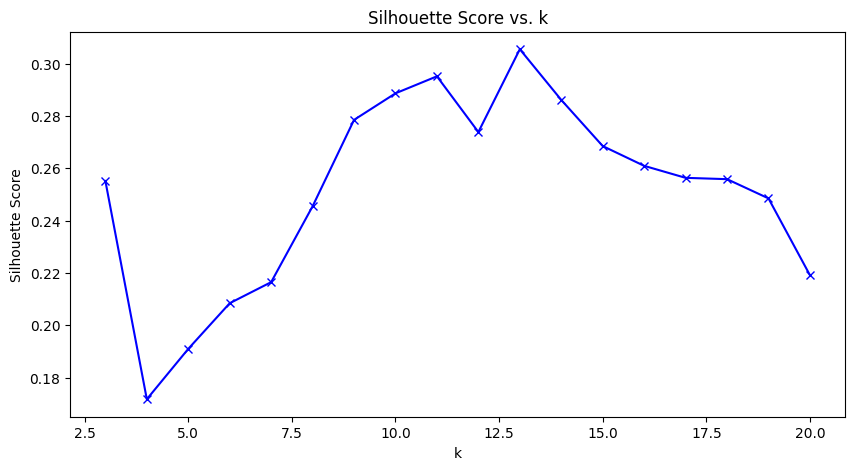

Best k value: 13


In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []
calinski_harabasz_scores = []

for k in range(3, 21):
  # 执行KMeans聚类
  kmeans = KMeans(n_clusters=k, random_state=42)
  labels = kmeans.fit_predict(X)

  # 计算轮廓系数
  si_score = silhouette_score(X, labels)
  silhouette_scores.append(si_score)

  # 计算Calinski-Harabasz Index
  ch_score = calinski_harabasz_score(X, labels)
  calinski_harabasz_scores.append(ch_score)

# 绘制轮廓系数与k的关系图
plt.figure(figsize=(10, 5))
plt.plot(range(3, 21), silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')
plt.show()

# 你可以选择轮廓系数最高的k值作为最优的聚类数量
best_k = range(3, 21)[silhouette_scores.index(max(silhouette_scores))]
print(f"Best k value: {best_k}")

<Figure size 1000x500 with 0 Axes>

Text(0.5, 0, 'k')

Text(0, 0.5, 'Calinski Harabasz Score')

Text(0.5, 1.0, 'Calinski Harabasz Score vs. k')

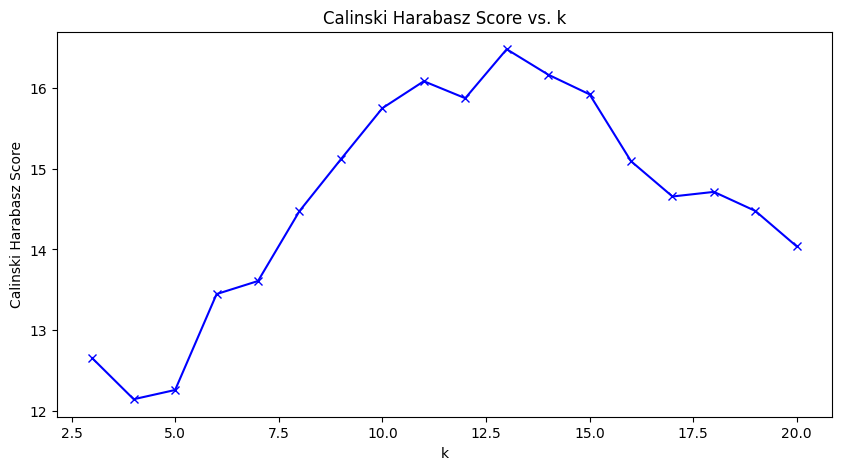

Best k value: 13


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(3, 21), calinski_harabasz_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Calinski Harabasz Score')
plt.title('Calinski Harabasz Score vs. k')
plt.show()

best_k = range(3, 21)[calinski_harabasz_scores.index(max(calinski_harabasz_scores))]
print(f"Best k value: {best_k}")

In [ ]:
num_clusters = 13
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)
labels = kmeans.fit_predict(X)
for i, file_name in enumerate(file_names):
    print(f"{file_name} belongs to cluster: {labels[i]}")

KMeans(n_clusters=13)

血だらけでチョコ配達⁉ バレンタインデーの失敗談6つ.txt belongs to cluster: 10
今なら笑える！片思い中の失敗エピソード.txt belongs to cluster: 11
【新大学生必見】これだけはやるな！入学直後の失敗談とそこから学ぶ教訓6選.txt belongs to cluster: 12
ホワイトデーで失敗…。良くないプレゼントや忘れていた悲しいエピソード.txt belongs to cluster: 10
やってしまった～！ お花見での失敗エピソード.txt belongs to cluster: 3
新入社員にアドバイス！ 働く女性100人がこっそり明かす “今だから言える“新人時代のやらかし話＆失敗のリカバリー法.txt belongs to cluster: 3
破局のきっかけになった！彼氏とのデートの失敗談5つ.txt belongs to cluster: 7
結納・顔合わせ食事会「こんなはずでは！」衝撃失敗談５.txt belongs to cluster: 1
大学生活の印象的な失敗談.txt belongs to cluster: 12
【新人は失敗だらけ？】入社一年目の失敗を出版社の先輩たちに聞いてみたら.txt belongs to cluster: 3
ＳＮＳへの投稿で「失敗した…」ことってある？.txt belongs to cluster: 7
定期テストでのハプニング・失敗談【中学生保護者の声】.txt belongs to cluster: 12
やってみたかった仕事に就いたのに……。こんなはずじゃなかった.txt belongs to cluster: 2
なんとなく転職したけど、私のやりたいことって本当にこれだっけ.txt belongs to cluster: 2
こんな大学の決め方は絶対NG！先輩が語る、進路選択の後悔体験談.txt belongs to cluster: 12
就活の面接時によくある失敗例｜学生による体験談や人事担当者の経験を紹介.txt belongs to cluster: 1
先輩のありがち失敗談に学ぶ！「新居選び＆引っ越し」成功術.txt belongs to cluster: 5
大

# wordcloud

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# 为每个聚类选择最具代表性的词汇
word_freq_dicts = {}
texts = df['text']

<Figure size 6000x4000 with 0 Axes>

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 0')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 1')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 2')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 3')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 4')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 5')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 6')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 7')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 8')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 9')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 10')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 11')

<Axes: >

(-0.5, 3199.5, 1599.5, -0.5)

Text(0.5, 1.0, 'Cluster 12')

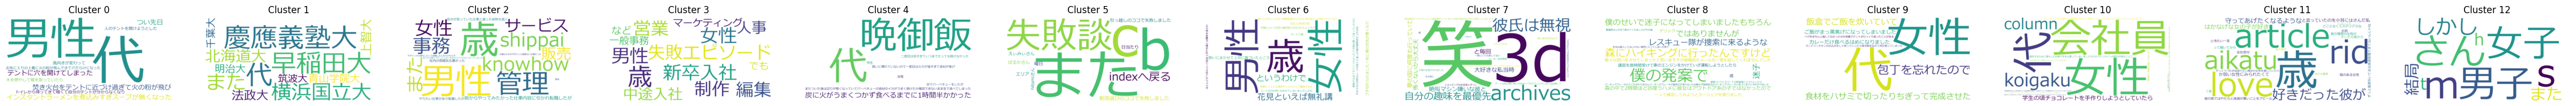

In [ ]:
for i in range(num_clusters):
    cluster_texts = [texts[j] for j in range(len(labels)) if labels[j] == i]
    cluster_words = ' '.join(cluster_texts).split()
    word_freq_dicts[i] = Counter(cluster_words)

# 绘制每个聚类的词云
plt.figure(figsize=(60, 40))
for i, (label, word_freq) in enumerate(word_freq_dicts.items()):
    # 选择最具代表性的N个词汇
    N = 20  # 例如，选择词频最高的前20个词
    top_words = word_freq.most_common(N)
    top_words_str = ' '.join([word for word, _ in top_words])

    font_path = '/content/drive/MyDrive/Meiryo.ttf'
    wordcloud = WordCloud(font_path=font_path, width=3200, height=1600, background_color='white',
                          stopwords=None, min_font_size=10).generate(top_words_str)
    plt.subplot(1, num_clusters, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'Cluster {label}')

plt.show()

In [ ]:
cluster_labels = kmeans.fit_predict(X.toarray())

# 为每个聚类创建语料库
corpora = []
for i in range(num_clusters):
    cluster_texts = [texts[j] for j in range(len(texts)) if cluster_labels[j] == i]
    cluster_dict = Dictionary(cluster_texts)
    corpora.append([cluster_dict.doc2bow(text) for text in cluster_texts])

# LDA建模
lda_models = []
for corpus in corpora:
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=corpus[0].id2word, passes=20)
    lda_models.append(lda_model)

# 可视化每个聚类的主题
for i, lda_model in enumerate(lda_models):
    topic_weights = lda_model.get_topic_weights()
    topic_terms = lda_model.print_topics()

    # 绘制条形图或其他类型的图
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(topic_weights)), topic_weights)
    plt.title(f'Cluster {i} Topic Weights')
    plt.xlabel('Topic')
    plt.ylabel('Weight')
    plt.xticks(range(len(topic_weights)), [f'Topic {j}' for j in range(len(topic_weights))])
    plt.show()

AttributeError: 'DataFrame' object has no attribute 'toarray'

In [ ]:
!pip install gensim
from gensim.corpora import Dictionary

cluster_labels = kmeans.fit_predict(X)

cluster_texts = []
for j in range(len(texts)):
    if cluster_labels[j] == i:
        cluster_texts.append(texts[j])

# 为每个聚类创建语料库
corpora = []
for i in range(num_clusters):
  cluster_dict = Dictionary(cluster_texts)
  corpora.append([cluster_dict.doc2bow(text) for text in cluster_texts])

# LDA建模
lda_models = []
for corpus in corpora:
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=corpus[0].id2word, passes=20)
    lda_models.append(lda_model)

# 可视化每个聚类的主题
for i, lda_model in enumerate(lda_models):
    topic_weights = lda_model.get_topic_weights()
    topic_terms = lda_model.print_topics()

    # 绘制条形图或其他类型的图
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(topic_weights)), topic_weights)
    plt.title(f'Cluster {i} Topic Weights')
    plt.xlabel('Topic')
    plt.ylabel('Weight')
    plt.xticks(range(len(topic_weights)), [f'Topic {j}' for j in range(len(topic_weights))])
    plt.show()

TypeError: doc2bow expects an array of unicode tokens on input, not a single string